
# Machine Learning — Notebook 00  
## La *filosofía* del **train / validation / test**: generalización, honestidad y ciencia reproducible

### Ideas centrales (que queremos motivar)
En ML no basta con “ajustar bien” los datos disponibles. Lo que realmente interesa es:

- **Generalizar**: que el modelo funcione en datos **nuevos** (no vistos).
- **Evaluar honestamente**: evitar auto-engañarnos con métricas infladas.
- **Tomar decisiones sin contaminar** el resultado final (selección de modelo, tuning, umbrales, features).

Este notebook explica **por qué** existe la filosofía de particionar en `train/validation/test` y lo ilustra con un ejemplo de **regresión lineal** usando `statsmodels`.

---

## 1) ¿Por qué split? (intuición, formalizada)

El argumento (correcto) puede formularse así:

### (a) Sin split no sabemos si el modelo “sirve para algo más”
Si ajustamos y evaluamos con *los mismos datos*, medimos desempeño **in-sample**. Eso no responde la pregunta científica/práctica:

> “¿Qué tan bien funcionará en datos nuevos?”

El split simula el futuro:
- `train` es “lo que sabemos hoy”.
- `test` es “lo que veremos mañana”, pero lo escondemos para evaluar de forma honesta.

### (b) ¿Qué pasa con puntos (semi)atípicos?
Un ejemplo también real: al agregar puntos que se salen de la tendencia, el ajuste cambia y el desempeño puede degradar.

Pero hay una sutileza importante:
- Un split aleatorio puede **dejar fuera** esos puntos del `train`, produciendo un ajuste “más bonito”…  
  **pero eso no significa que el modelo sea mejor**: significa que el `train` no fue representativo del mundo real.
- Precisamente por eso evaluamos en **test**, y por eso es clave discutir *shift* de distribución, robustez y estabilidad.

En otras palabras:
> El split no “mejora” el modelo mágicamente; nos da una forma de **medir** si generaliza, y de detectar cuando nuestro muestreo no representa el futuro.

### (c) Tercera justificación (muy importante): decisiones metodológicas sin contaminar el resultado
Durante el desarrollo siempre decidimos:
- hiperparámetros,
- selección de variables,
- transformaciones,
- umbrales,
- comparación de modelos.

Si usamos `test` para escoger, **dejamos de tener test** (lo contaminamos).  
Por eso existe `validation`: para tomar decisiones, y dejar `test` como evaluación final **una sola vez**.

---
## 2) Tamaños típicos de partición (heurística razonable)
No hay un número universal, pero hay reglas prácticas:

- Dataset “mediano”: **70/15/15** o **60/20/20**.
- Dataset pequeño: el split puede ser muy inestable → preferimos **cross-validation** (lo verás en semanas 14–15).
- Series de tiempo: *split temporal* (no aleatorio) para evitar fuga del futuro.

En este notebook usaremos **60/20/20** para ver claramente el rol de cada conjunto.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

RANDOM_STATE = 7
rng = np.random.default_rng(RANDOM_STATE)

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 120)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def fit_ols(X, y):
    Xc = sm.add_constant(X, has_constant="add")
    return sm.OLS(y, Xc).fit()



---
## 3) Experimento: regresión lineal con datos “limpios” y luego (semi)atípicos

### Diseño del experimento
1. Generamos ~25 puntos con una tendencia lineal + ruido.
2. Ajustamos OLS con **todos** esos datos y reportamos métricas *in-sample*.
3. Luego agregamos 2–3 puntos “nuevos” que se salen un poco de la tendencia (simulando cambio de condiciones / outliers / drift).
4. Volvemos a ajustar y comparamos:
   - coeficientes,
   - ajuste visual,
   - métricas *in-sample* vs desempeño en “datos nuevos”.

Después haremos el enfoque ML:
- split `train/val/test`,
- entrenar en train,
- decidir en val,
- evaluar en test.


In [2]:

# 3.1 Datos base (25 puntos) con relación lineal
n0 = 25
x0 = np.linspace(0, 10, n0)
y0 = 3.0 + 2.0*x0 + rng.normal(0, 1.0, size=n0)

df0 = pd.DataFrame({"x": x0, "y": y0})
df0.head()


,x,y
0,0.000000,3.001230
1,0.416667,4.132079
2,0.833333,4.392529
3,1.250000,4.609408
4,1.666667,5.878663


In [3]:

# Ajuste OLS con todos los datos base
res0 = fit_ols(df0[["x"]], df0["y"])
print(res0.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1360.
Date:                Wed, 04 Feb 2026   Prob (F-statistic):           5.75e-22
Time:                        19:53:50   Log-Likelihood:                -28.410
No. Observations:                  25   AIC:                             60.82
Df Residuals:                      23   BIC:                             63.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9828      0.305      9.774      0.0

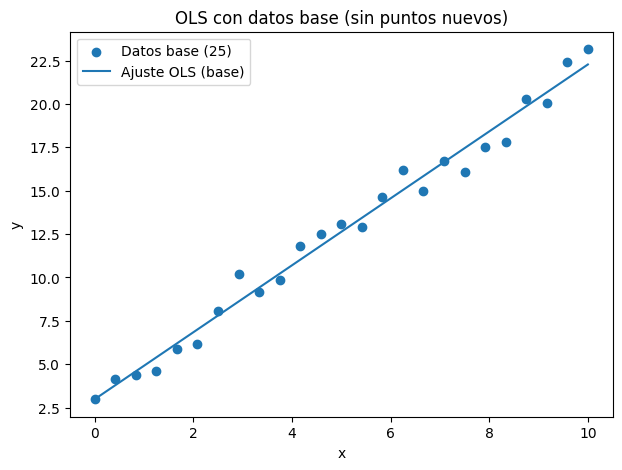

In-sample R2: 0.9833714470699758
In-sample RMSE: 0.7538770830118865


In [4]:

# Visualización del ajuste
x_grid = np.linspace(df0["x"].min(), df0["x"].max(), 200)
y_hat0 = res0.predict(sm.add_constant(x_grid))

plt.figure(figsize=(7,5))
plt.scatter(df0["x"], df0["y"], label="Datos base (25)")
plt.plot(x_grid, y_hat0, label="Ajuste OLS (base)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("OLS con datos base (sin puntos nuevos)")
plt.legend()
plt.show()

# Métricas in-sample
y_pred0 = res0.predict(sm.add_constant(df0["x"]))
print("In-sample R2:", r2_score(df0["y"], y_pred0))
print("In-sample RMSE:", rmse(df0["y"], y_pred0))



### Agregamos datos “nuevos” (semi)atípicos
Estos puntos simulan observaciones futuras que cambian un poco el patrón (por ejemplo, nuevas condiciones, medición distinta, etc.).


In [5]:

# 3.2 Agregar puntos nuevos (semi-atípicos)
x_new = np.array([11.0, 12.0, 13.0])

# Generamos y con una "deriva" (drift) o desviación respecto a la recta original
# Por ejemplo: mismo slope pero intercepto menor + ruido grande, o puntos por debajo.
y_new = 3.0 + 2.0*x_new + np.array([-6.0, -8.0, -10.0]) + rng.normal(0, 0.8, size=len(x_new))

df_new = pd.DataFrame({"x": x_new, "y": y_new, "tag": "nuevo"})
df_all = pd.concat([df0.assign(tag="base"), df_new], ignore_index=True)

df_all.tail()


,x,y,tag
23,9.583333,22.437931,base
24,10.000000,23.156751,base
25,11.000000,18.850455,nuevo
26,12.000000,16.986592,nuevo
27,13.000000,18.569046,nuevo


In [6]:

# Ajuste OLS con TODOS los datos (base + nuevos)
res_all = fit_ols(df_all[["x"]], df_all["y"])

print("Coeficientes (base):", res0.params.to_dict())
print("Coeficientes (base+nuevos):", res_all.params.to_dict())


Coeficientes (base): {'const': 2.9827883216528566, 'x': 1.9294862134951376}
Coeficientes (base+nuevos): {'const': 4.595093013231303, 'x': 1.499993624327326}


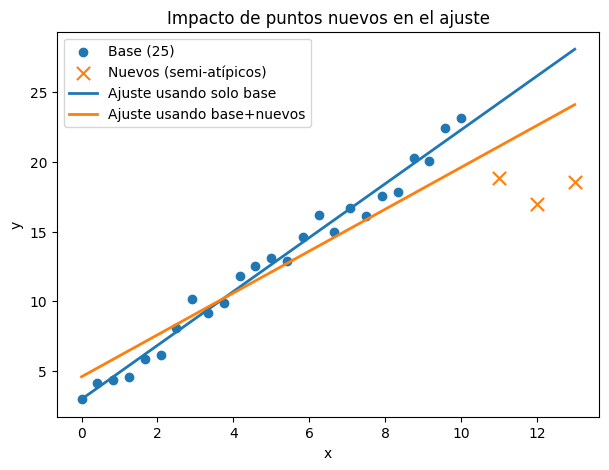

In [7]:

# Visualización comparativa
x_grid2 = np.linspace(df_all["x"].min(), df_all["x"].max(), 250)
y_hat_base = res0.predict(sm.add_constant(x_grid2))
y_hat_all  = res_all.predict(sm.add_constant(x_grid2))

plt.figure(figsize=(7,5))
plt.scatter(df_all.query("tag=='base'")["x"], df_all.query("tag=='base'")["y"], label="Base (25)")
plt.scatter(df_all.query("tag=='nuevo'")["x"], df_all.query("tag=='nuevo'")["y"], label="Nuevos (semi-atípicos)", marker="x", s=90)
plt.plot(x_grid2, y_hat_base, label="Ajuste usando solo base", linewidth=2)
plt.plot(x_grid2, y_hat_all,  label="Ajuste usando base+nuevos", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Impacto de puntos nuevos en el ajuste")
plt.legend()
plt.show()


In [8]:

# Métricas in-sample (comparación)
y_pred_all_in = res_all.predict(sm.add_constant(df_all["x"]))
print("In-sample (base+nuevos) R2 :", r2_score(df_all["y"], y_pred_all_in))
print("In-sample (base+nuevos) RMSE:", rmse(df_all["y"], y_pred_all_in))

# Pero lo interesante: ¿cómo predice el modelo entrenado SOLO en base, sobre los puntos nuevos?
y_new_pred_by_base = res0.predict(sm.add_constant(df_new["x"]))
print("\nDesempeño del modelo 'base' sobre puntos nuevos:")
print("RMSE sobre nuevos:", rmse(df_new["y"], y_new_pred_by_base))


In-sample (base+nuevos) R2 : 0.8613238069653232
In-sample (base+nuevos) RMSE: 2.1549725632868477

Desempeño del modelo 'base' sobre puntos nuevos:
RMSE sobre nuevos: 8.218096095807686



**Interpretación**
- Ajustar con *todo* (incluyendo puntos nuevos) cambia los coeficientes: el modelo intenta “explicar” también esos casos.
- Ajustar con solo el dataset base puede verse excelente **en-sample**, pero puede fallar en los datos nuevos (eso es precisamente el problema).

Aquí es donde la filosofía ML entra: necesitamos un mecanismo para **estimar** generalización sin “ver el futuro”.



---
## 4) Enfoque ML: `train/val/test` para estimar generalización

Ahora vamos a:
1) Hacer split **antes** de ajustar.
2) Entrenar en `train`.
3) Usar `val` para decisiones (en este notebook solo lo usaremos para observar estabilidad).
4) Evaluar en `test` una sola vez.

Además mostraremos una idea clave:
> Con datasets pequeños y/o con outliers, un split aleatorio puede ser inestable. Por eso (más adelante) usaremos cross-validation.


In [9]:

# 4.1 Split 60/20/20 (aleatorio) sobre el dataset completo
X = df_all[["x"]].copy()
y = df_all["y"].copy()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE  # 0.25 de 0.8 => 0.2 total
)

res_tr = fit_ols(X_train, y_train)

# Métricas en val y test
y_val_pred = res_tr.predict(sm.add_constant(X_val["x"]))
y_test_pred = res_tr.predict(sm.add_constant(X_test["x"]))

print("Coeficientes (train):", res_tr.params.to_dict())
print("RMSE val :", rmse(y_val, y_val_pred))
print("RMSE test:", rmse(y_test, y_test_pred))


Coeficientes (train): {'const': 4.371896867736831, 'x': 1.5852954009594793}
RMSE val : 3.2114601286284787
RMSE test: 1.0142058258390079


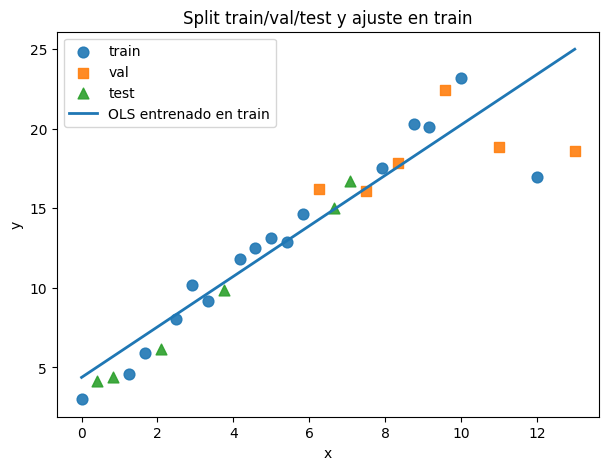

In [10]:

# Visualización: qué cayó en train/val/test
df_all2 = df_all.copy()
df_all2["split"] = "?"

df_all2.loc[X_train.index, "split"] = "train"
df_all2.loc[X_val.index, "split"]   = "val"
df_all2.loc[X_test.index, "split"]  = "test"

plt.figure(figsize=(7,5))
for sp, marker in [("train","o"), ("val","s"), ("test","^")]:
    sub = df_all2[df_all2["split"] == sp]
    plt.scatter(sub["x"], sub["y"], label=sp, marker=marker, s=60, alpha=0.9)

x_grid3 = np.linspace(df_all2["x"].min(), df_all2["x"].max(), 250)
plt.plot(x_grid3, res_tr.predict(sm.add_constant(x_grid3)), linewidth=2, label="OLS entrenado en train")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Split train/val/test y ajuste en train")
plt.legend()
plt.show()



### ¿Qué enseña este gráfico?
- Si los puntos “nuevos” (semi-atípicos) caen en `test`, el error en test puede aumentar (y eso es informativo).
- Si por azar esos puntos caen en `train`, el modelo se ajusta a ellos y el test puede verse más fácil.

Por eso, en doctorado, una idea central es **estabilidad**:
- repetimos splits (o usamos CV) para ver la variación del desempeño.


In [11]:

# 4.2 Estabilidad: repetir splits y ver distribución del RMSE en test
def one_split_rmse(seed):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.20, random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=seed
    )
    res = fit_ols(X_train, y_train)
    y_test_pred = res.predict(sm.add_constant(X_test["x"]))
    return rmse(y_test, y_test_pred)

seeds = list(range(1, 201))
rmses = np.array([one_split_rmse(s) for s in seeds])

pd.Series(rmses).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])


count    200.000000
mean       2.375044
std        1.000259
min        0.602968
10%        1.230632
25%        1.574102
50%        2.299782
75%        2.881998
90%        3.502780
max        5.974436
dtype: float64

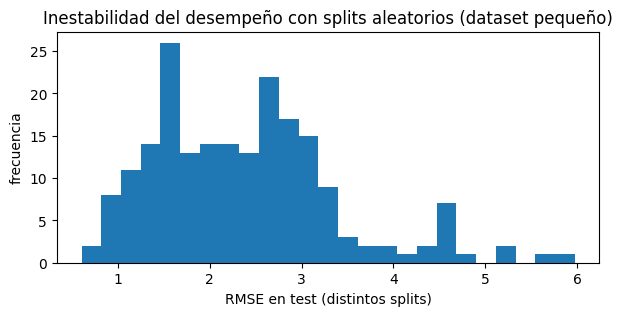

In [12]:

plt.figure(figsize=(7,3))
plt.hist(rmses, bins=25)
plt.xlabel("RMSE en test (distintos splits)")
plt.ylabel("frecuencia")
plt.title("Inestabilidad del desempeño con splits aleatorios (dataset pequeño)")
plt.show()



**Conclusión importante**
- Con pocos datos y/o con puntos raros, el desempeño medido en un único split puede variar mucho.
- Esto refuerza la filosofía: el split es el inicio de la “honestidad”, y luego usamos **cross-validation** y/o **splits por tiempo/grupo** según el problema.

---
## 5) Resumen (lo que queremos que quede instalado)

1) **Split existe para estimar generalización**: separar lo que usamos para aprender de lo que usamos para evaluar.
2) `validation` existe para **tomar decisiones** sin contaminar `test`.
3) Los tamaños del split dependen del tamaño y naturaleza del dataset; con pocos datos la evaluación es inestable → CV.
4) Tu ejemplo (puntos semi-atípicos) es clave para motivar **shift**, robustez y estabilidad.  
   Un split no “mejora” el modelo; **revela** si el modelo se sostiene en datos que no vio.

---
## 6) Ejercicios (cortos)

1) Ajusta el experimento para que los puntos nuevos sigan una pendiente diferente (cambio de slope). ¿Qué pasa?
2) Cambia el número de puntos base (25 → 60) y repite el análisis de estabilidad (histograma de RMSE). ¿Qué observas?
3) Si el problema fuera serie de tiempo (x=tiempo), ¿harías split aleatorio? ¿por qué?
